In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)  
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 83.2537
0 -> 5 -> 3 -> 31 -> 42 -> 21 -> 13 -> 7 -> 18 -> 44 -> 36 -> 2 -> 27 -> 11 -> 47 -> 30 -> 10 -> 25 -> 46 -> 19 -> 6 -> 14 -> 39 -> 26 -> 35 -> 33 -> 49 -> 8 -> 22 -> 9 -> 24 -> 15 -> 29 -> 48 -> 17 -> 34 -> 32 -> 4 -> 43 -> 45 -> 23 -> 20 -> 12 -> 41 -> 40 -> 28 -> 38 -> 1 -> 37 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.41it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.80it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.31it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.49it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/20 [01:07<?, ?it/s]

Epoch   0, Train Regret: 329.3519%, Val Regret: 337.8251%


Epoch    0, Loss:  27.1839:   5%|██▊                                                    | 1/20 [02:14<24:12, 76.47s/it]

Epoch   1, Train Regret:  46.1844%, Val Regret:  47.4684%


Epoch    1, Loss:  24.6667:  10%|█████▌                                                 | 2/20 [03:12<19:51, 66.21s/it]

Epoch   2, Train Regret:  43.2151%, Val Regret:  43.8271%


Epoch    2, Loss:  10.4194:  15%|████████▎                                              | 3/20 [04:11<17:41, 62.43s/it]

Epoch   3, Train Regret:  42.1781%, Val Regret:  43.0032%


Epoch    3, Loss:  11.7285:  20%|███████████                                            | 4/20 [05:10<16:20, 61.30s/it]

Epoch   4, Train Regret:  40.6724%, Val Regret:  41.8218%


Epoch    4, Loss:  12.0927:  25%|█████████████▊                                         | 5/20 [06:09<15:05, 60.34s/it]

Epoch   5, Train Regret:  38.5003%, Val Regret:  39.4238%


Epoch    5, Loss:   9.6509:  30%|████████████████▌                                      | 6/20 [07:07<13:56, 59.77s/it]

Epoch   6, Train Regret:  35.9708%, Val Regret:  37.3799%


Epoch    6, Loss:   8.6855:  35%|███████████████████▎                                   | 7/20 [08:06<12:51, 59.37s/it]

Epoch   7, Train Regret:  33.8930%, Val Regret:  35.1133%


Epoch    7, Loss:   7.2262:  40%|██████████████████████                                 | 8/20 [09:05<11:50, 59.24s/it]

Epoch   8, Train Regret:  31.8780%, Val Regret:  33.2835%


Epoch    8, Loss:  10.4598:  45%|████████████████████████▊                              | 9/20 [10:04<10:49, 59.07s/it]

Epoch   9, Train Regret:  30.8282%, Val Regret:  31.8872%


Epoch    9, Loss:   7.9238:  50%|███████████████████████████                           | 10/20 [11:02<09:49, 58.99s/it]

Epoch  10, Train Regret:  29.9372%, Val Regret:  31.2683%


Epoch   10, Loss:  14.3332:  55%|█████████████████████████████▋                        | 11/20 [12:00<08:48, 58.70s/it]

Epoch  11, Train Regret:  29.4907%, Val Regret:  30.7722%


Epoch   11, Loss:   4.5611:  60%|████████████████████████████████▍                     | 12/20 [12:58<07:47, 58.44s/it]

Epoch  12, Train Regret:  29.3633%, Val Regret:  30.5883%


Epoch   12, Loss:   6.3709:  65%|███████████████████████████████████                   | 13/20 [13:56<06:49, 58.44s/it]

Epoch  13, Train Regret:  28.8848%, Val Regret:  30.1597%


Epoch   13, Loss:   7.4022:  70%|█████████████████████████████████████▊                | 14/20 [14:53<05:49, 58.19s/it]

Epoch  14, Train Regret:  28.8599%, Val Regret:  29.7811%


Epoch   14, Loss:  10.2233:  75%|████████████████████████████████████████▌             | 15/20 [15:51<04:49, 57.99s/it]

Epoch  15, Train Regret:  28.6626%, Val Regret:  30.1044%


Epoch   15, Loss:  16.6805:  80%|███████████████████████████████████████████▏          | 16/20 [16:50<03:52, 58.01s/it]

Epoch  16, Train Regret:  28.7899%, Val Regret:  29.9768%


Epoch   16, Loss:   8.3793:  85%|█████████████████████████████████████████████▉        | 17/20 [17:49<03:08, 62.92s/it]


Epoch  17, Train Regret:  28.9071%, Val Regret:  29.8066%

Early Stop!

Evaluation:
Test Regret: 29.2286%
Training Elapsed Time: 9.96 Sec


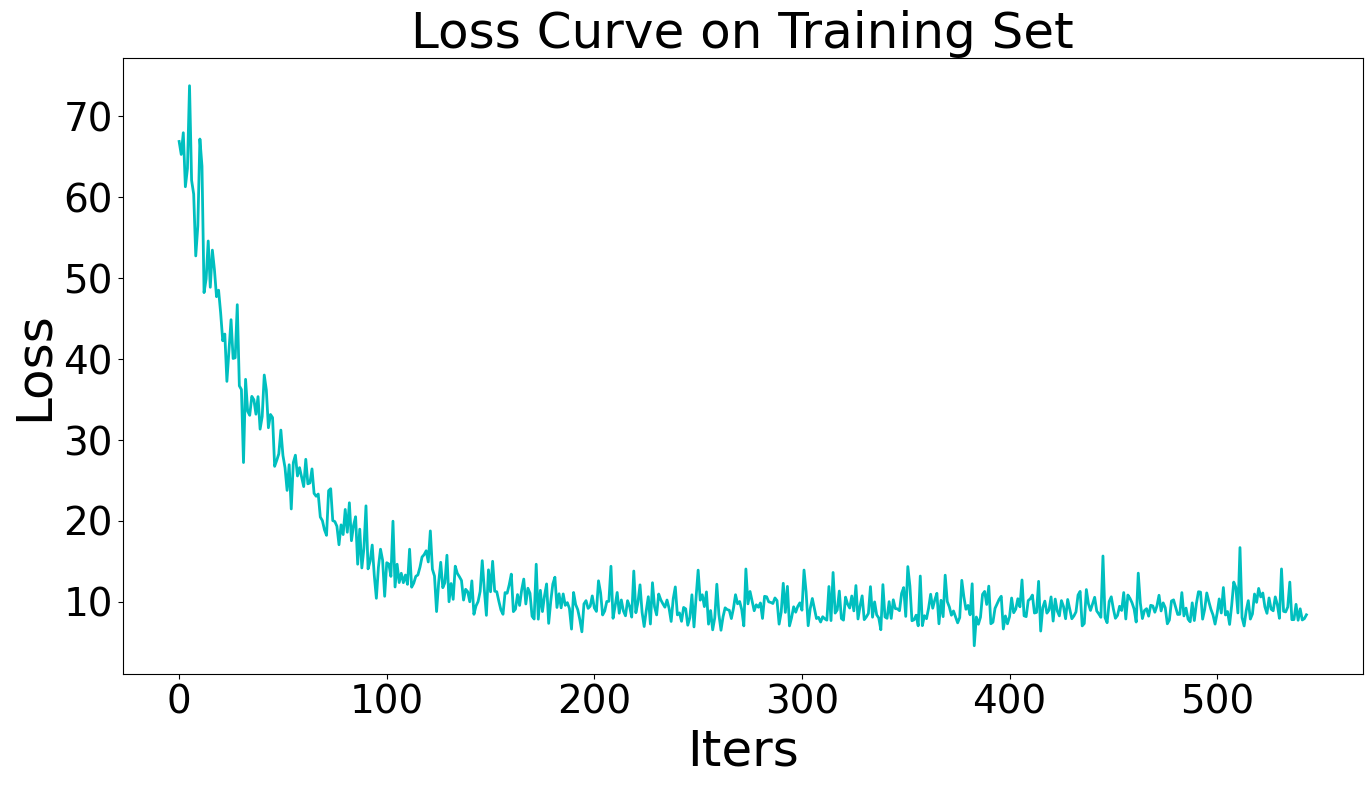

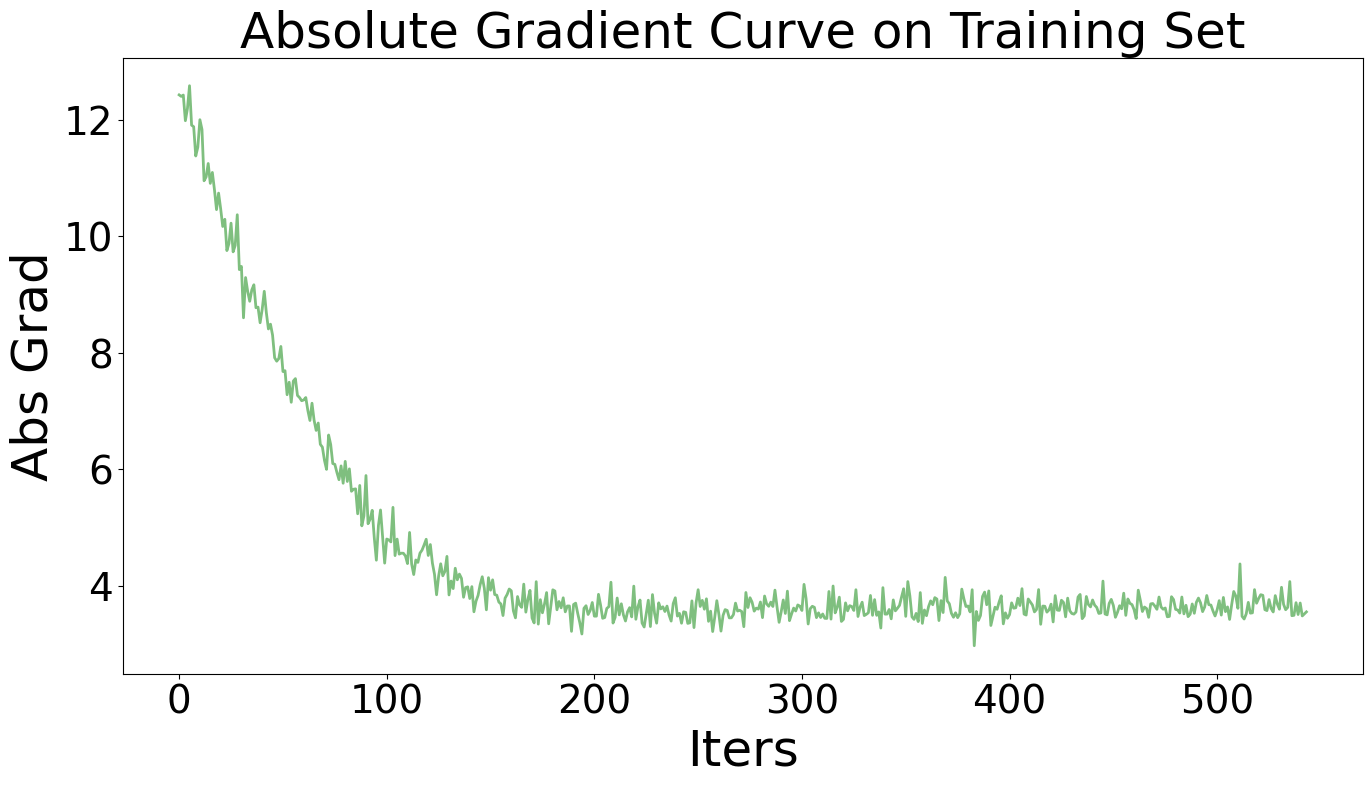

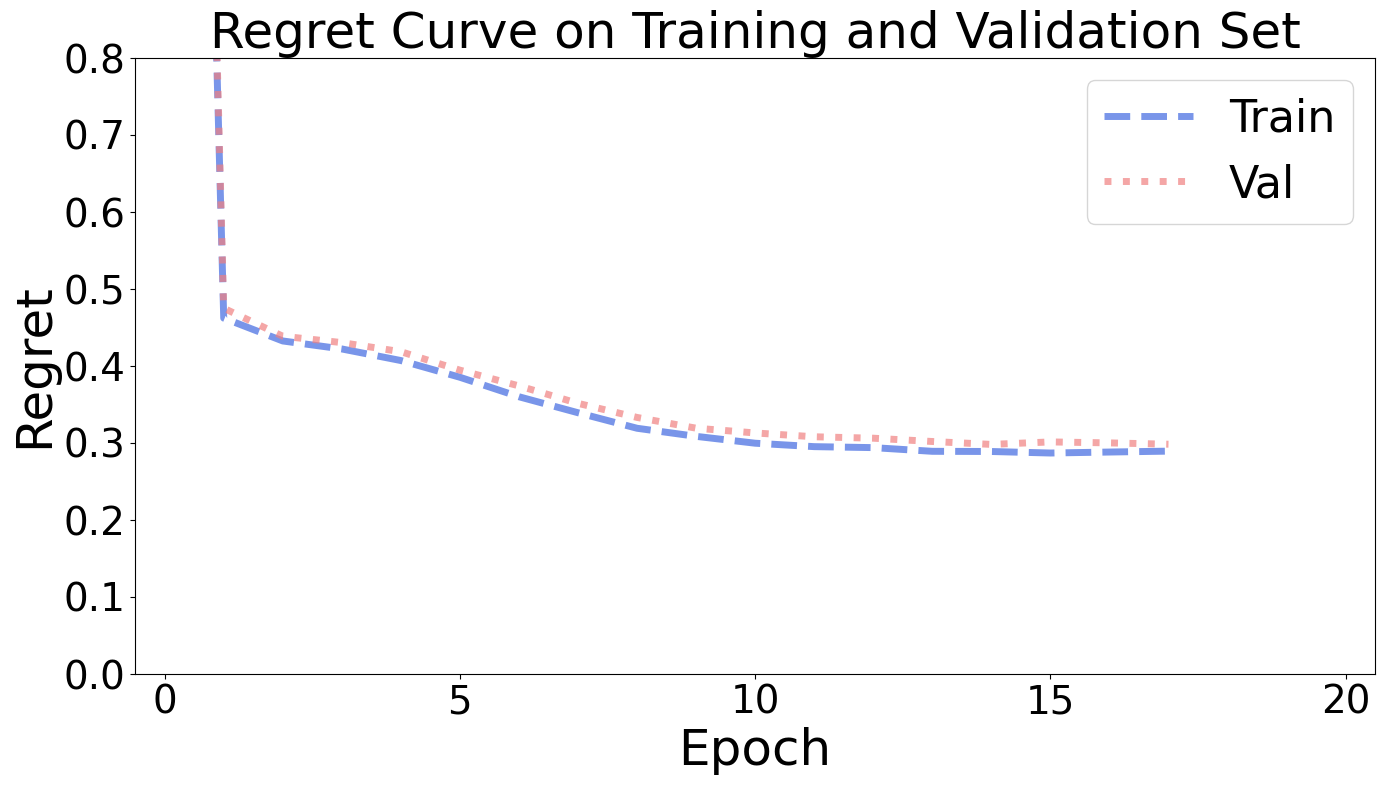

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:57<?, ?it/s]

Epoch   0, Train Regret: 319.7730%, Val Regret: 329.2941%


Epoch    0, Loss:  -0.9986:   5%|██▋                                                   | 1/20 [03:51<53:56, 170.32s/it]

Epoch   1, Train Regret:  24.6385%, Val Regret:  30.3647%


Epoch    1, Loss:  -0.9994:  10%|█████▍                                                | 2/20 [05:59<42:22, 141.27s/it]

Epoch   2, Train Regret:  16.2672%, Val Regret:  20.7263%


Epoch    2, Loss:  -0.9996:  15%|████████                                              | 3/20 [08:17<37:52, 133.65s/it]

Epoch   3, Train Regret:  13.7630%, Val Regret:  18.8476%


Epoch    3, Loss:  -0.9997:  20%|██████████▊                                           | 4/20 [10:26<35:21, 132.60s/it]

Epoch   4, Train Regret:  12.4978%, Val Regret:  17.8991%


Epoch    4, Loss:  -0.9997:  25%|█████████████▌                                        | 5/20 [12:52<33:48, 135.24s/it]

Epoch   5, Train Regret:  12.0634%, Val Regret:  17.3406%


Epoch    5, Loss:  -0.9998:  30%|████████████████▏                                     | 6/20 [14:54<31:29, 134.99s/it]

Epoch   6, Train Regret:  11.3554%, Val Regret:  17.4593%


Epoch    6, Loss:  -0.9998:  35%|██████████████████▉                                   | 7/20 [17:34<29:07, 134.42s/it]

Epoch   7, Train Regret:  11.2681%, Val Regret:  16.1714%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [19:46<28:26, 142.23s/it]

Epoch   8, Train Regret:  10.8502%, Val Regret:  16.8381%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [22:05<25:05, 136.89s/it]

Epoch   9, Train Regret:  10.3494%, Val Regret:  16.2909%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [24:10<22:35, 135.52s/it]

Epoch  10, Train Regret:  10.8589%, Val Regret:  17.3081%

Early Stop!


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [24:10<24:10, 145.10s/it]



Evaluation:
Test Regret: 16.1930%
Training Elapsed Time: 589.81 Sec


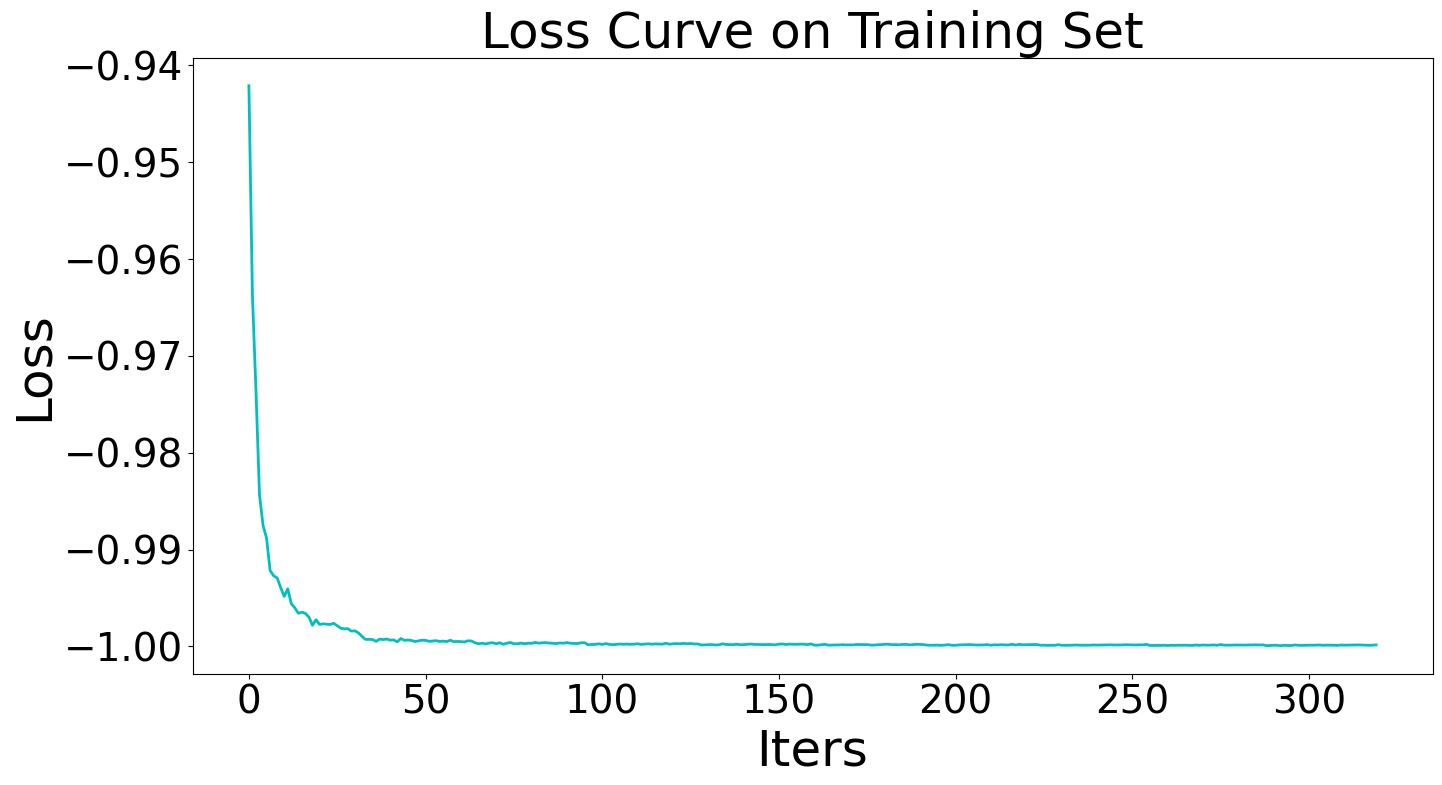

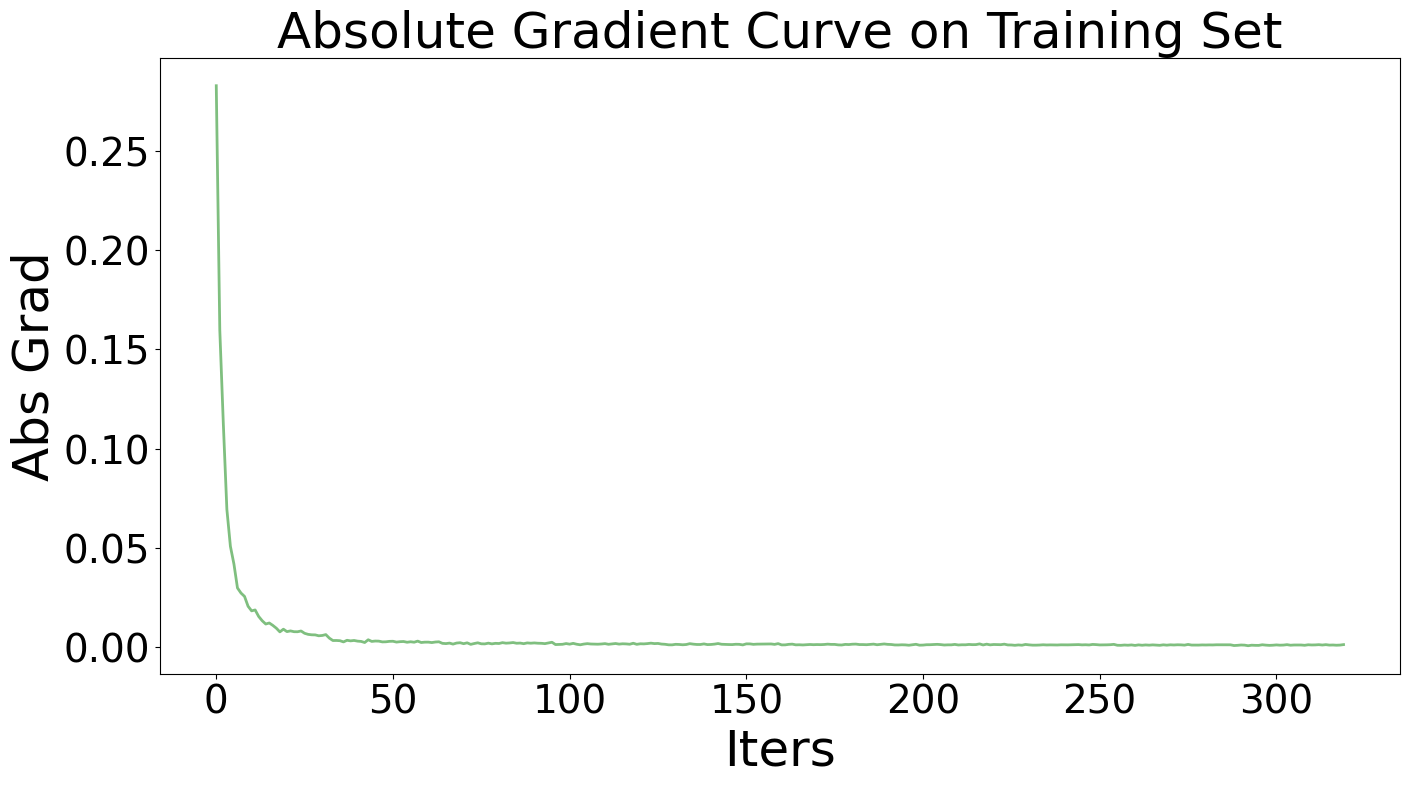

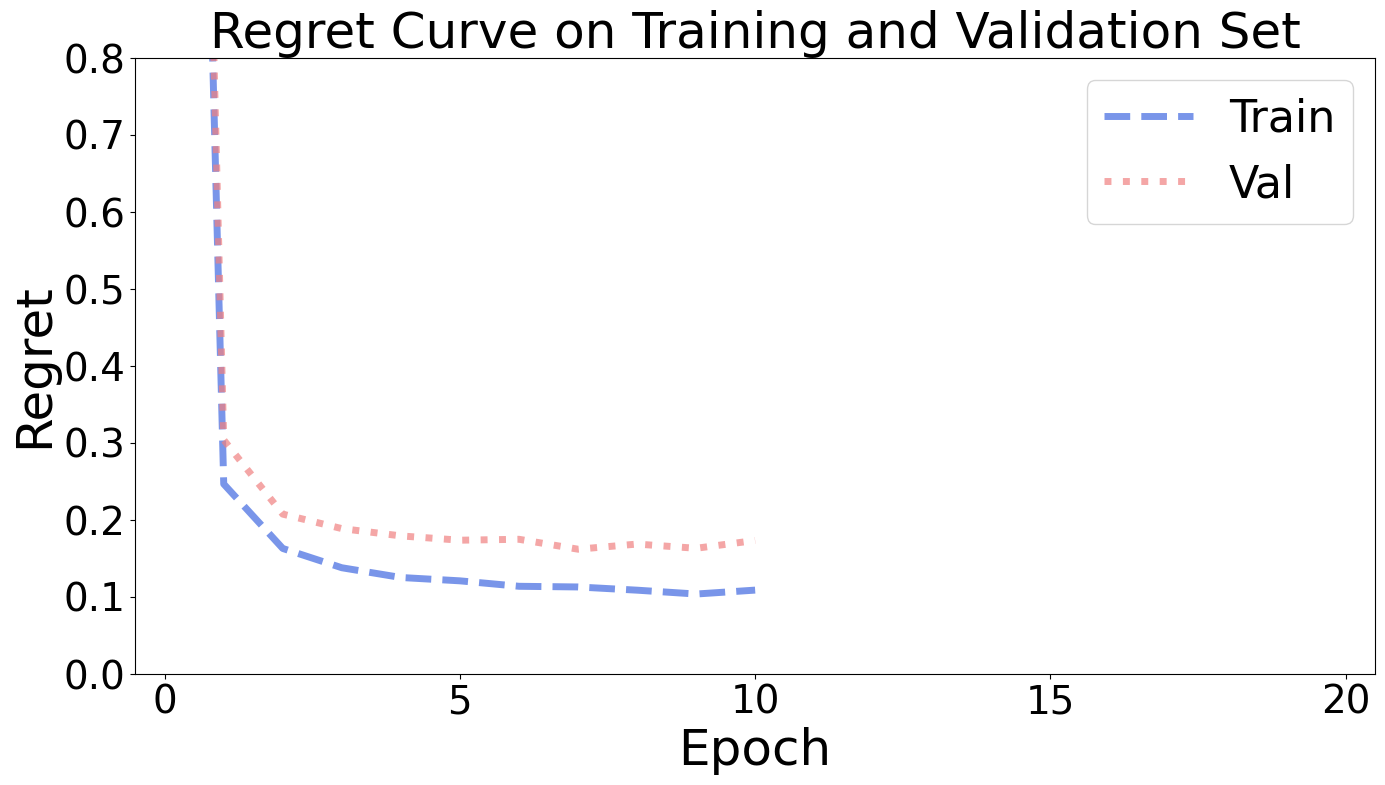

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [22]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:58<?, ?it/s]

Epoch   0, Train Regret: 321.2164%, Val Regret: 325.3359%


Epoch    0, Loss:  -0.9964:   5%|██▋                                                   | 1/20 [03:00<33:35, 106.06s/it]

Epoch   1, Train Regret:   9.6312%, Val Regret:  11.3210%


Epoch    1, Loss:  -0.9966:  10%|█████▍                                                | 2/20 [05:08<34:25, 114.73s/it]

Epoch   2, Train Regret:   6.9520%, Val Regret:   7.8717%


Epoch    2, Loss:  -0.9960:  15%|████████                                              | 3/20 [07:11<34:23, 121.36s/it]

Epoch   3, Train Regret:   6.8001%, Val Regret:   7.8111%


Epoch    3, Loss:  -0.9960:  20%|██████████▊                                           | 4/20 [09:21<32:16, 121.00s/it]

Epoch   4, Train Regret:   6.7216%, Val Regret:   7.5975%


Epoch    4, Loss:  -0.9956:  25%|█████████████▌                                        | 5/20 [12:26<33:44, 134.97s/it]

Epoch   5, Train Regret:   6.8183%, Val Regret:   7.7318%


Epoch    5, Loss:  -0.9963:  30%|████████████████▏                                     | 6/20 [14:39<33:26, 143.29s/it]

Epoch   6, Train Regret:   6.8902%, Val Regret:   8.0996%


Epoch    6, Loss:  -0.9964:  35%|██████████████████▉                                   | 7/20 [16:30<29:54, 138.04s/it]

Epoch   7, Train Regret:   6.8051%, Val Regret:   7.4517%


Epoch    7, Loss:  -0.9968:  40%|█████████████████████▌                                | 8/20 [18:31<26:03, 130.27s/it]

Epoch   8, Train Regret:   6.7467%, Val Regret:   7.9395%


Epoch    8, Loss:  -0.9968:  45%|████████████████████████▎                             | 9/20 [20:29<23:15, 126.86s/it]

Epoch   9, Train Regret:   6.7783%, Val Regret:   7.5228%


Epoch    9, Loss:  -0.9961:  50%|██████████████████████████▌                          | 10/20 [22:27<20:37, 123.74s/it]

Epoch  10, Train Regret:   6.7292%, Val Regret:   7.9458%

Early Stop!


Epoch    9, Loss:  -0.9961:  50%|██████████████████████████▌                          | 10/20 [22:27<22:27, 134.74s/it]



Evaluation:
Test Regret: 7.7882%
Training Elapsed Time: 470.25 Sec


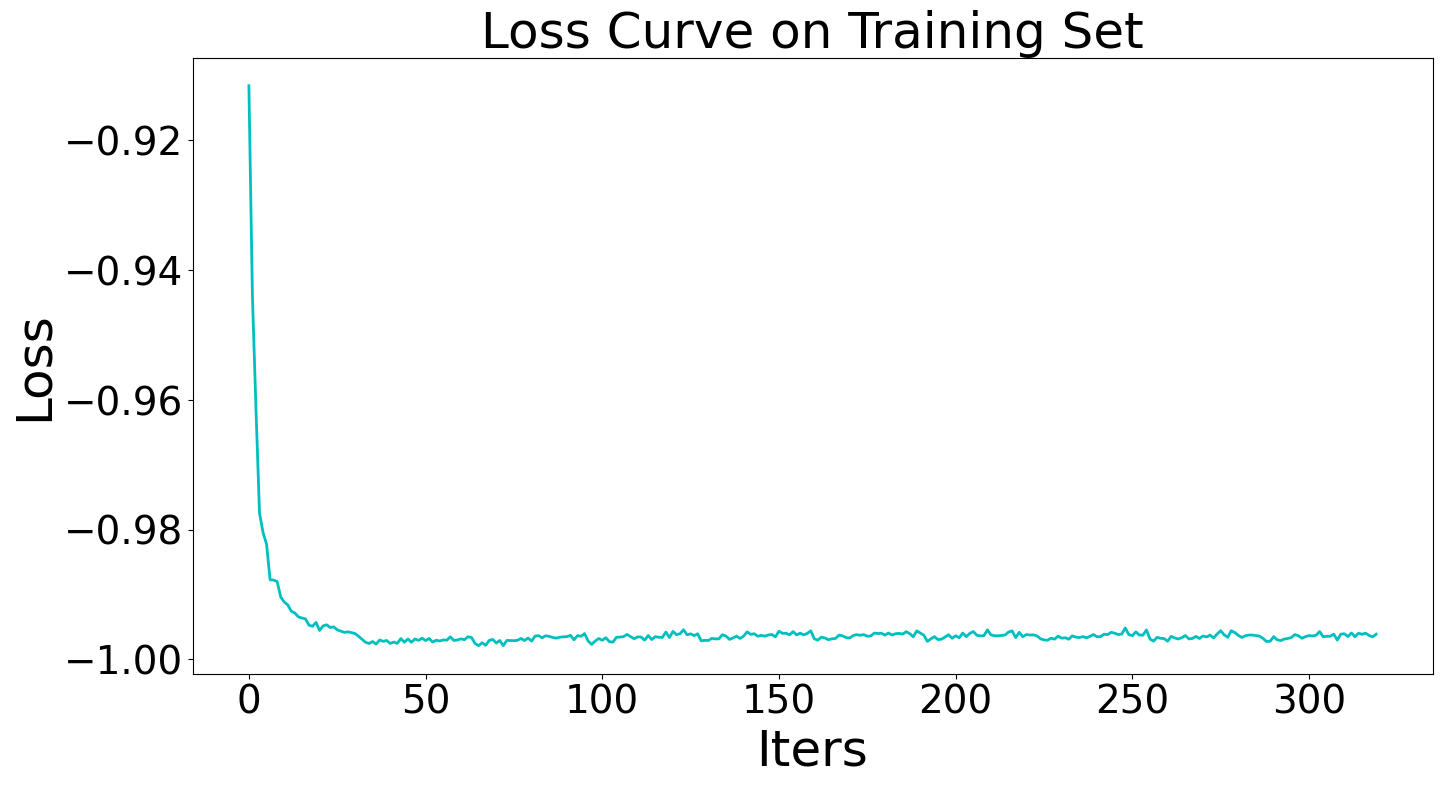

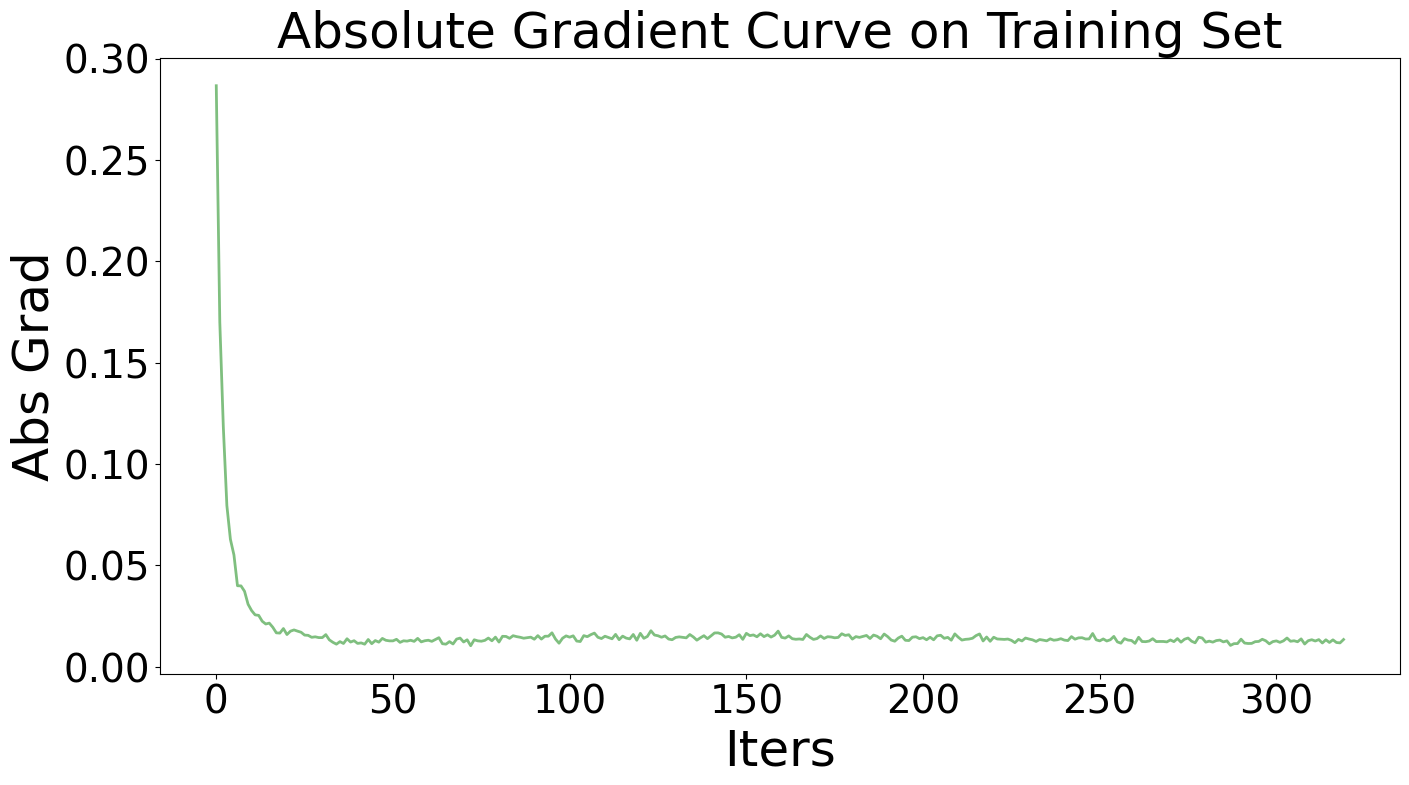

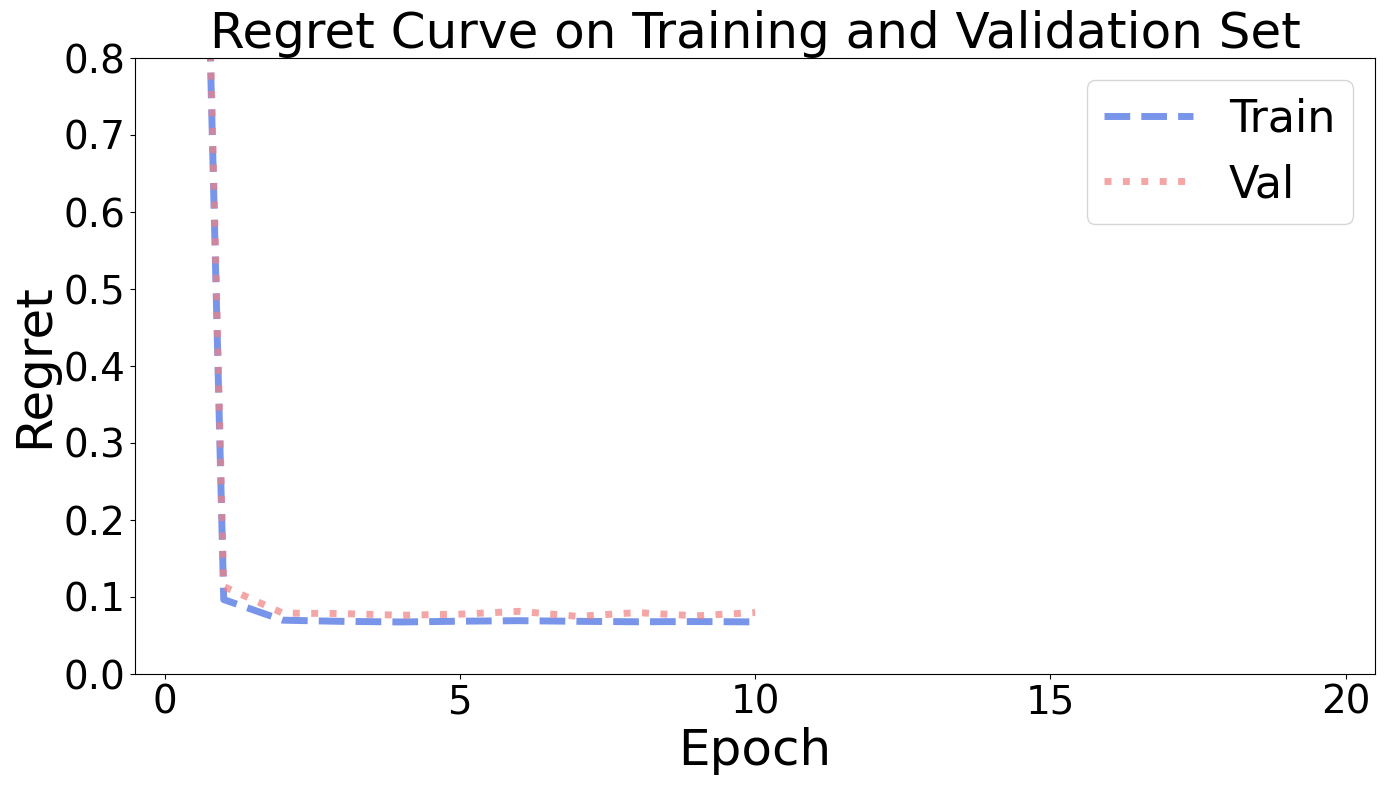

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method 

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [26]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [01:04<?, ?it/s]

Epoch   0, Train Regret: 321.2164%, Val Regret: 325.3359%


Epoch    0, Loss:  -0.9962:   5%|██▋                                                   | 1/20 [04:09<38:06, 120.33s/it]

Epoch   1, Train Regret:  13.7691%, Val Regret:  15.4587%


Epoch    1, Loss:  -1.0000:  10%|█████▍                                                | 2/20 [06:07<43:12, 144.05s/it]

Epoch   2, Train Regret:   9.2504%, Val Regret:  10.4564%


Epoch    2, Loss:  -1.0000:  15%|████████                                              | 3/20 [07:33<36:10, 127.68s/it]

Epoch   3, Train Regret:   8.7250%, Val Regret:   9.7892%


Epoch    3, Loss:  -1.0000:  20%|██████████▊                                           | 4/20 [09:11<30:05, 112.87s/it]

Epoch   4, Train Regret:   8.5095%, Val Regret:   9.8136%


Epoch    4, Loss:  -1.0000:  25%|█████████████▌                                        | 5/20 [11:04<27:21, 109.41s/it]

Epoch   5, Train Regret:   8.2852%, Val Regret:   9.7438%


Epoch    5, Loss:  -1.0000:  30%|████████████████▏                                     | 6/20 [12:40<25:25, 108.98s/it]

Epoch   6, Train Regret:   8.3015%, Val Regret:   9.0999%


Epoch    6, Loss:  -1.0000:  35%|██████████████████▉                                   | 7/20 [14:07<22:31, 103.95s/it]

Epoch   7, Train Regret:   8.7167%, Val Regret:   9.8484%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [15:44<19:45, 98.77s/it]

Epoch   8, Train Regret:   8.6487%, Val Regret:   9.6049%


Epoch    8, Loss:  -1.0000:  45%|████████████████████████▊                              | 9/20 [17:06<17:43, 96.67s/it]

Epoch   9, Train Regret:   9.5293%, Val Regret:  10.6328%

Early Stop!


Epoch    8, Loss:  -1.0000:  45%|████████████████████████▎                             | 9/20 [17:06<20:55, 114.10s/it]



Evaluation:
Test Regret: 9.3580%
Training Elapsed Time: 250.92 Sec


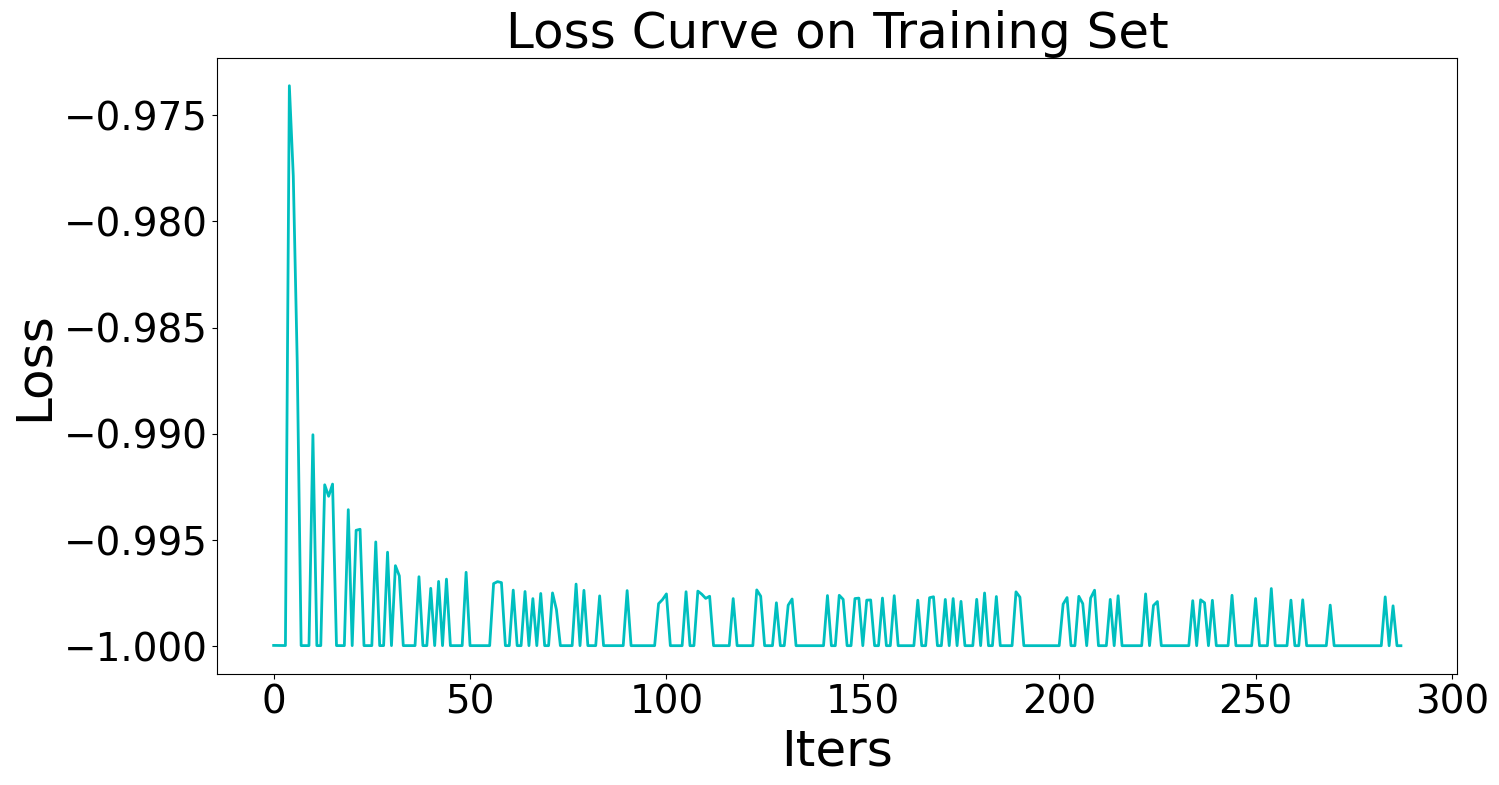

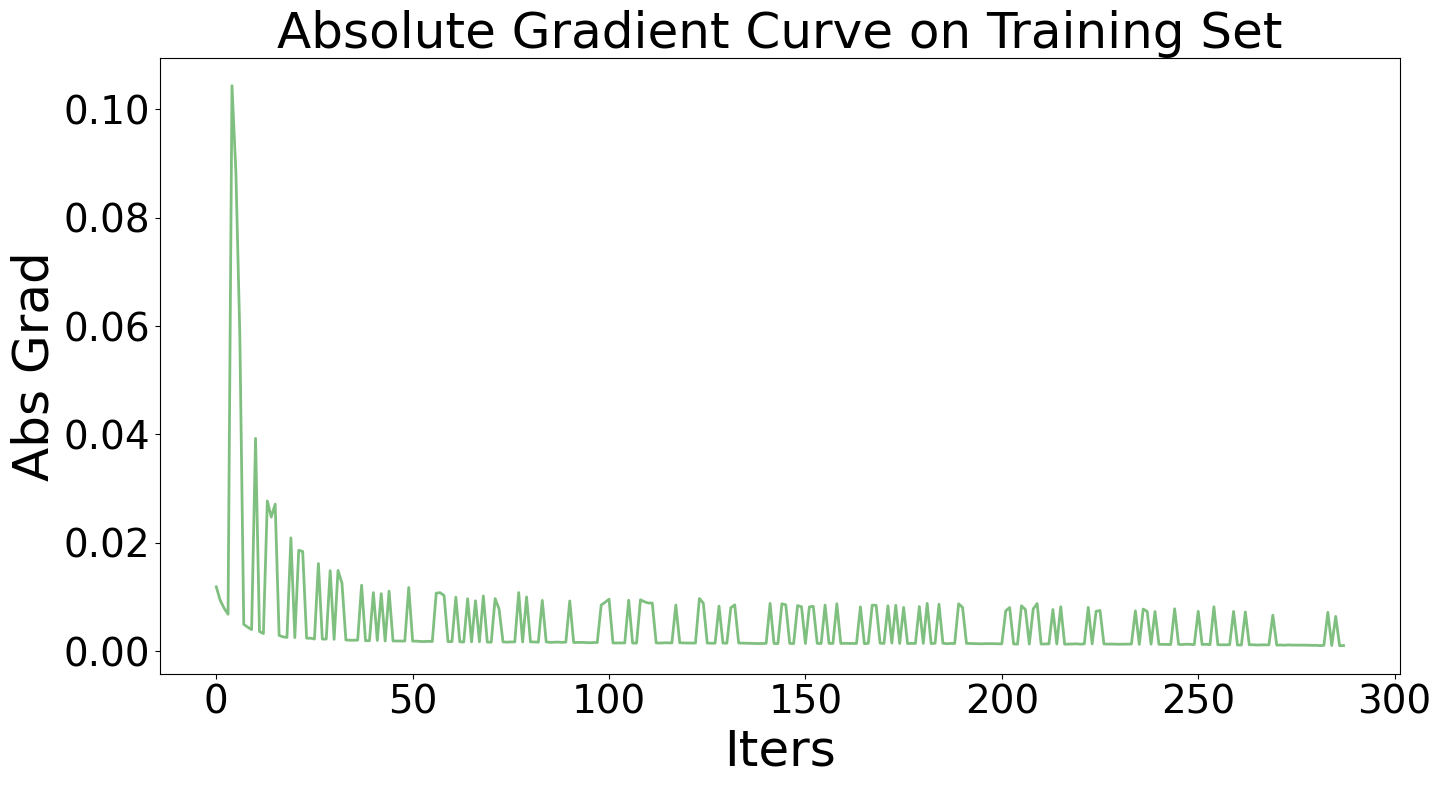

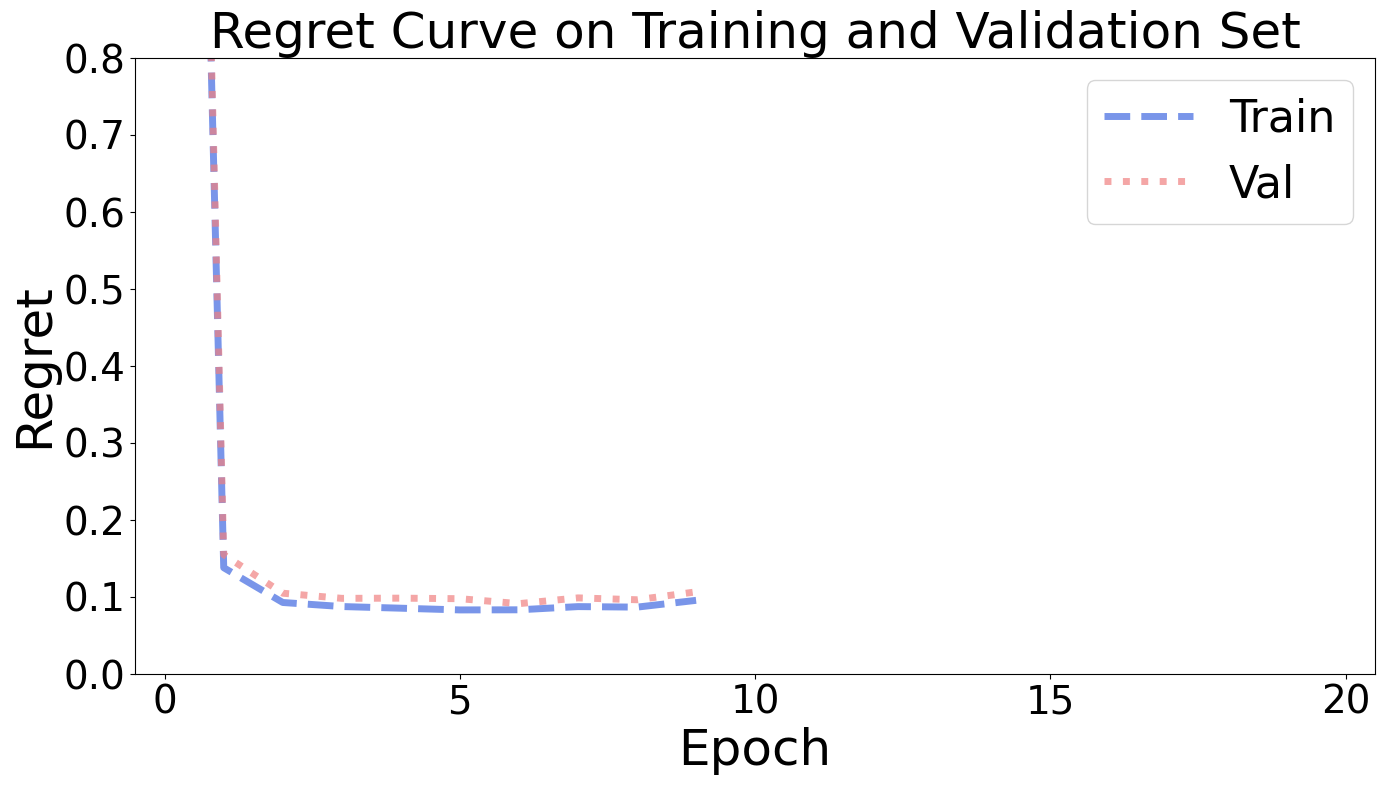

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [30]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:55<?, ?it/s]

Epoch   0, Train Regret: 320.7157%, Val Regret: 329.0384%


Epoch    0, Loss:  -1.0000:   5%|██▊                                                    | 1/20 [02:23<22:00, 69.51s/it]

Epoch   1, Train Regret:  42.9162%, Val Regret:  44.2790%


Epoch    1, Loss:  -1.0000:  10%|█████▌                                                 | 2/20 [03:50<23:58, 79.92s/it]

Epoch   2, Train Regret:  22.6295%, Val Regret:  24.1189%


Epoch    2, Loss:  -1.0000:  15%|████████▎                                              | 3/20 [05:14<23:44, 83.82s/it]

Epoch   3, Train Regret:  22.8525%, Val Regret:  24.8509%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [06:55<22:49, 85.60s/it]

Epoch   4, Train Regret:  22.8683%, Val Regret:  24.4120%


Epoch    4, Loss:  -1.0000:  25%|█████████████▊                                         | 5/20 [08:13<22:12, 88.85s/it]

Epoch   5, Train Regret:  22.7139%, Val Regret:  23.5687%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [09:40<20:00, 85.76s/it]

Epoch   6, Train Regret:  23.6109%, Val Regret:  23.6522%


Epoch    6, Loss:  -1.0000:  35%|███████████████████▎                                   | 7/20 [11:10<18:33, 85.68s/it]

Epoch   7, Train Regret:  23.1087%, Val Regret:  24.7095%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [12:29<18:44, 93.71s/it]


Epoch   8, Train Regret:  22.7497%, Val Regret:  24.5679%

Early Stop!

Evaluation:
Test Regret: 24.2098%
Training Elapsed Time: 104.89 Sec


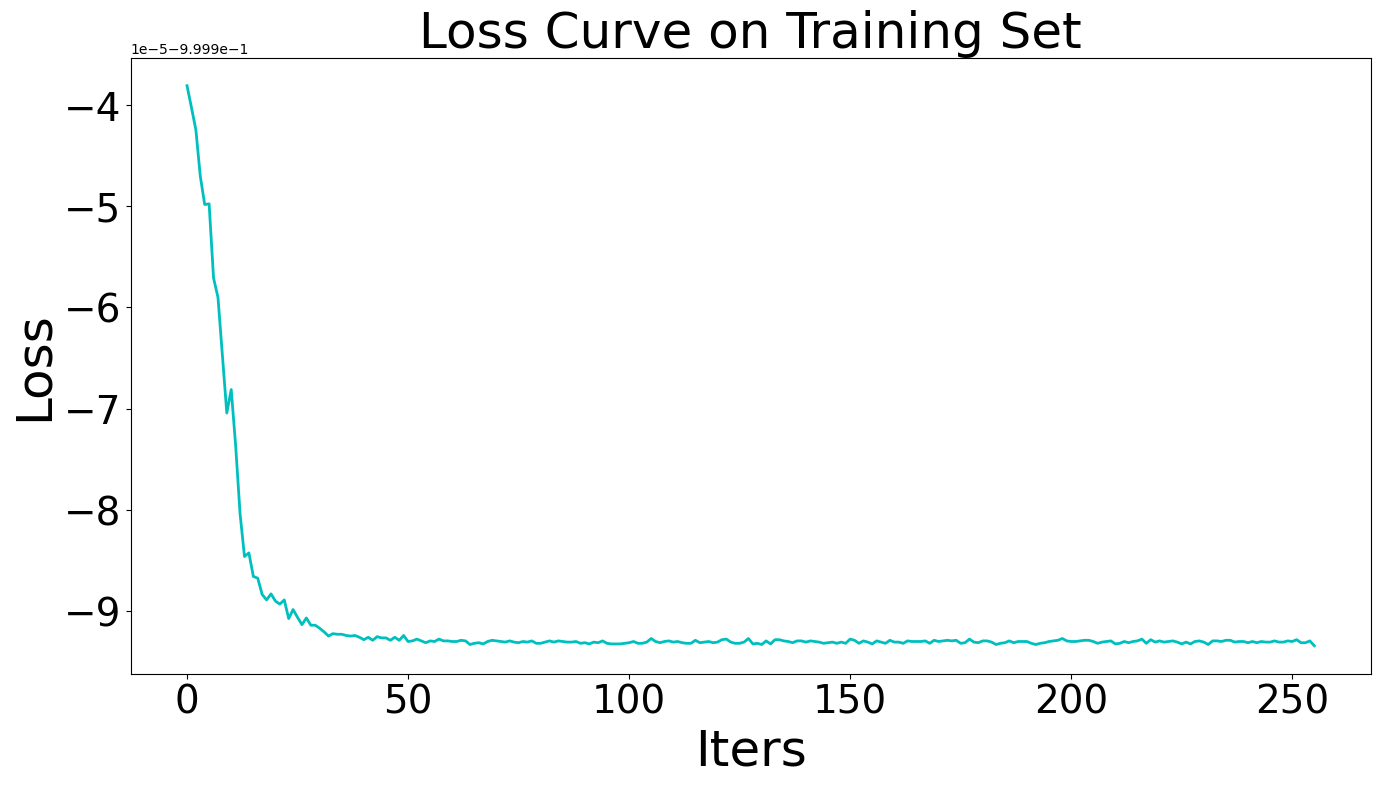

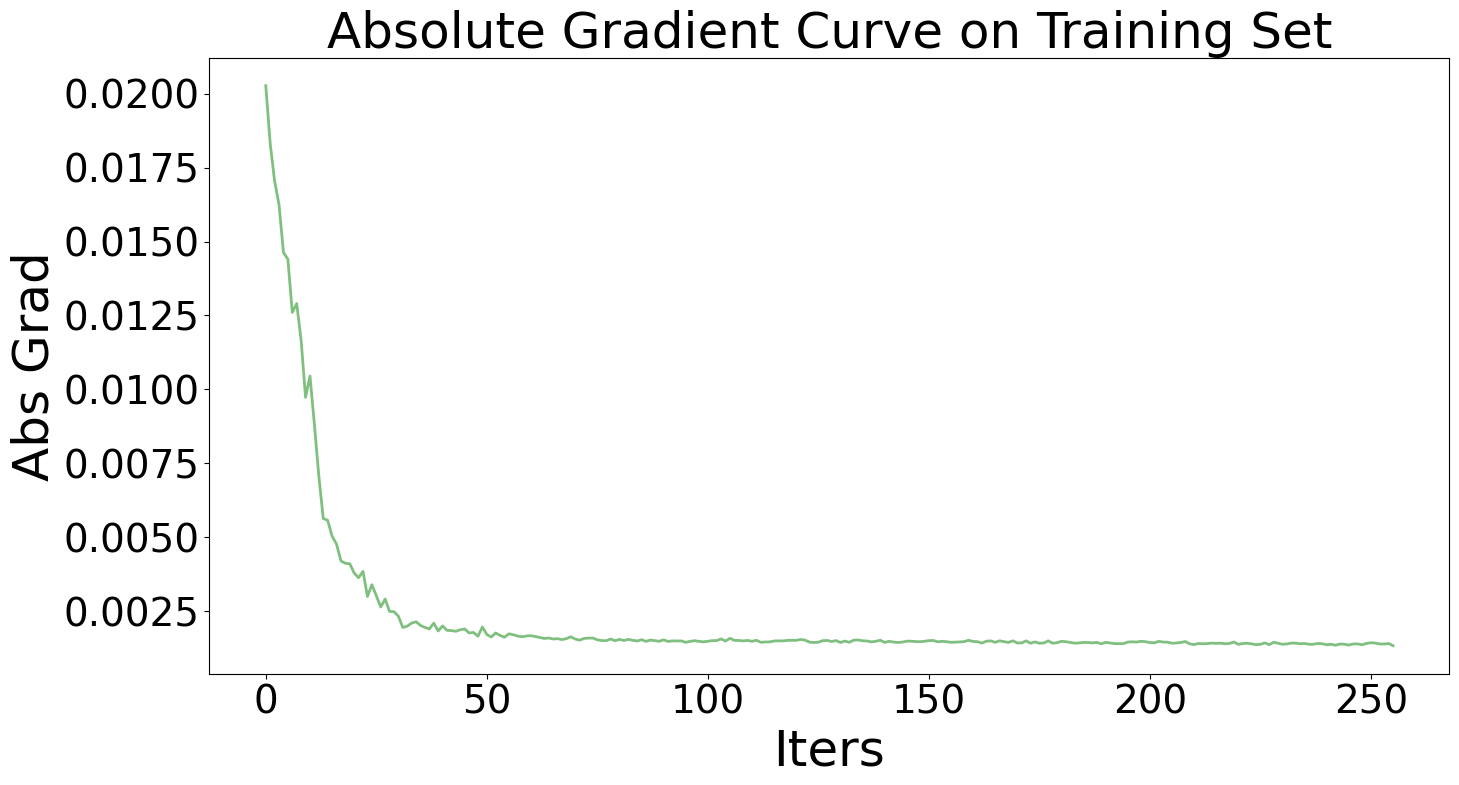

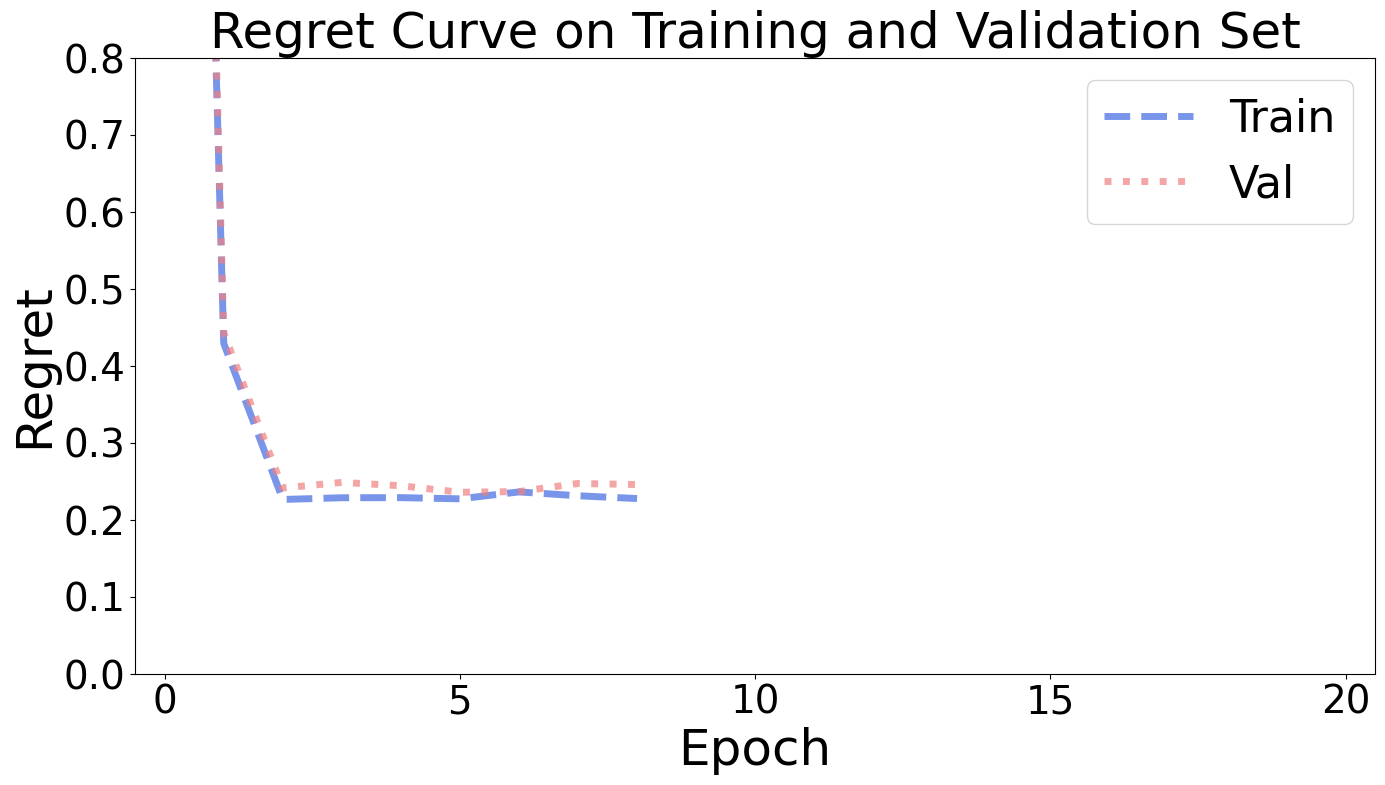

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True, processes=8)

Num of cores: 8


In [34]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:54<?, ?it/s]

Epoch   0, Train Regret: 319.1504%, Val Regret: 324.8218%


Epoch    0, Loss:  -1.0000:   5%|██▌                                                 | 1/20 [09:29<2:33:15, 483.95s/it]

Epoch   1, Train Regret:  42.3622%, Val Regret:  43.0641%


Epoch    1, Loss:  -1.0000:  10%|█████▏                                              | 2/20 [16:03<2:13:07, 443.74s/it]

Epoch   2, Train Regret:  22.6643%, Val Regret:  24.2712%


Epoch    2, Loss:  -1.0000:  15%|███████▊                                            | 3/20 [23:05<2:00:15, 424.45s/it]

Epoch   3, Train Regret:  22.8153%, Val Regret:  25.0884%


Epoch    3, Loss:  -1.0000:  20%|██████████▍                                         | 4/20 [29:51<1:52:17, 421.07s/it]

Epoch   4, Train Regret:  23.0049%, Val Regret:  24.3674%


Epoch    4, Loss:  -1.0000:  25%|█████████████                                       | 5/20 [36:19<1:43:12, 412.83s/it]

Epoch   5, Train Regret:  22.6051%, Val Regret:  23.6670%


Epoch    5, Loss:  -1.0000:  30%|███████████████▌                                    | 6/20 [43:06<1:34:55, 406.85s/it]

Epoch   6, Train Regret:  23.4527%, Val Regret:  23.7150%


Epoch    6, Loss:  -1.0000:  35%|██████████████████▏                                 | 7/20 [49:34<1:27:32, 404.05s/it]

Epoch   7, Train Regret:  23.0413%, Val Regret:  25.1352%


Epoch    7, Loss:  -1.0000:  40%|████████████████████▊                               | 8/20 [56:18<1:24:28, 422.35s/it]


Epoch   8, Train Regret:  22.8756%, Val Regret:  25.4370%

Early Stop!

Evaluation:
Test Regret: 24.0442%
Training Elapsed Time: 2722.37 Sec


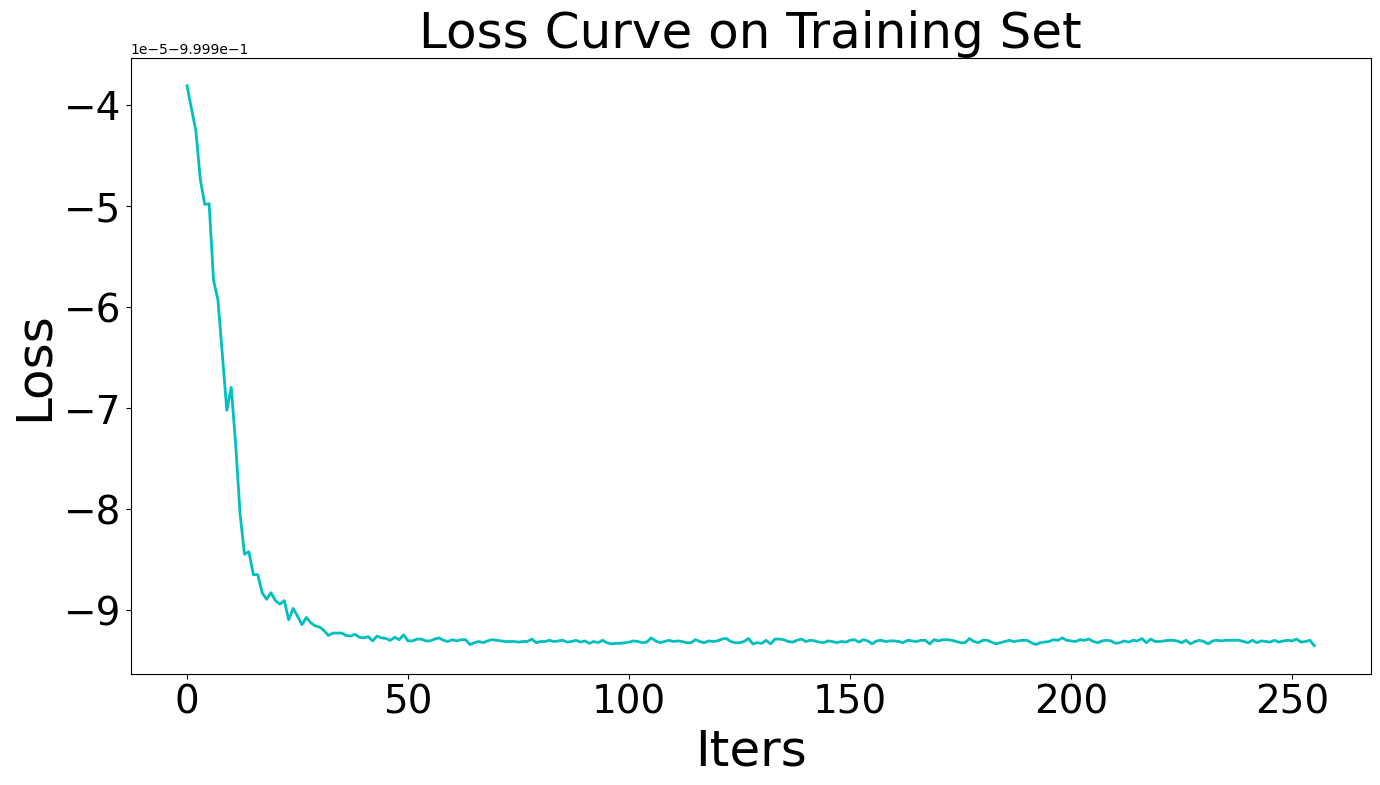

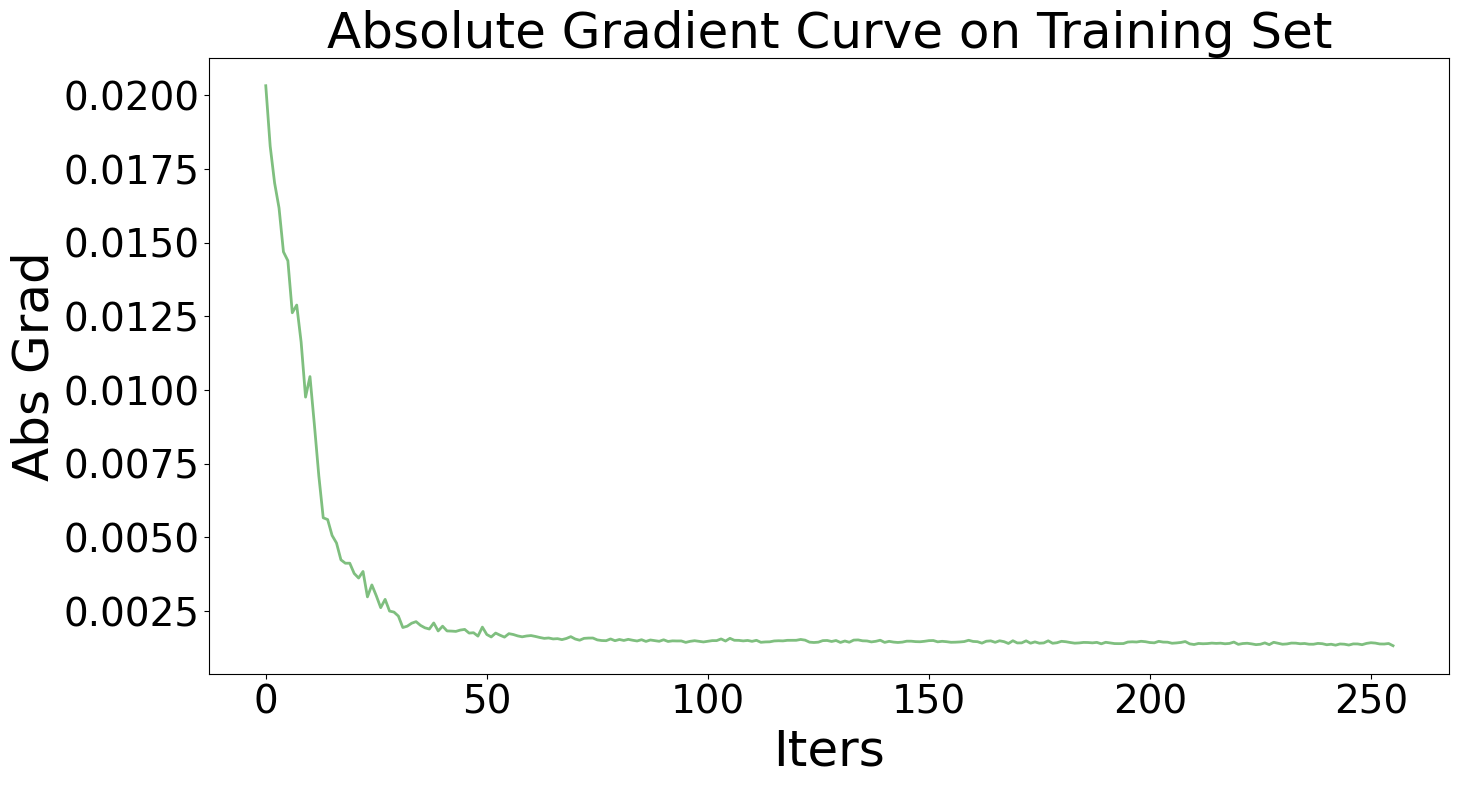

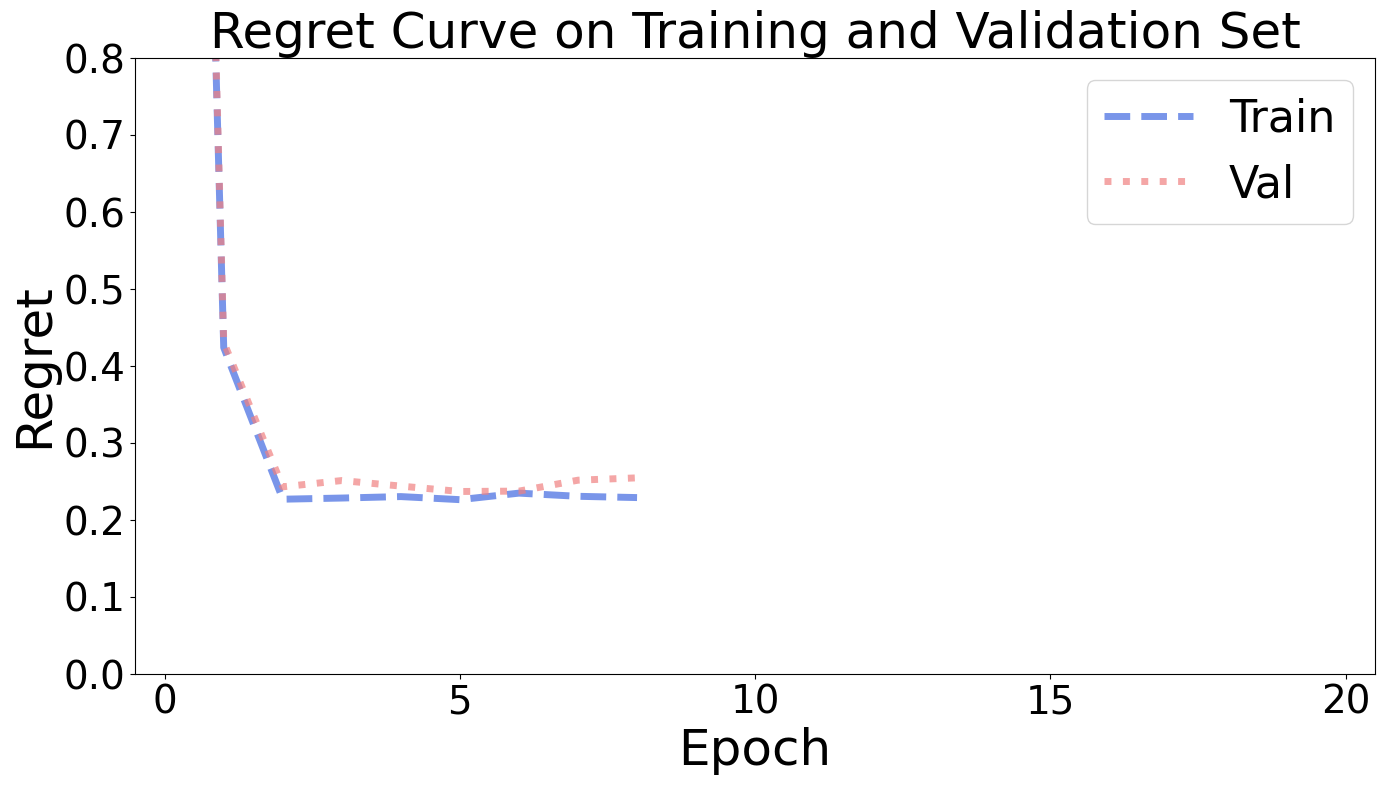

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:54<?, ?it/s]

Epoch   0, Train Regret: 319.1504%, Val Regret: 324.8218%


Epoch    0, Loss:  57.0000:   5%|██▊                                                    | 1/20 [02:21<25:54, 81.80s/it]

Epoch   1, Train Regret:  11.8889%, Val Regret:  13.3117%


Epoch    1, Loss:  50.0000:  10%|█████▍                                                | 2/20 [05:49<32:14, 107.46s/it]

Epoch   2, Train Regret:   8.5913%, Val Regret:   9.5466%


Epoch    2, Loss:  49.2500:  15%|████████                                              | 3/20 [07:32<39:56, 141.00s/it]

Epoch   3, Train Regret:   8.1213%, Val Regret:   9.2983%


Epoch    3, Loss:  44.2500:  20%|██████████▊                                           | 4/20 [09:06<32:48, 123.04s/it]

Epoch   4, Train Regret:   7.7372%, Val Regret:   8.6792%


Epoch    4, Loss:  44.5000:  25%|█████████████▌                                        | 5/20 [10:38<27:45, 111.00s/it]

Epoch   5, Train Regret:   7.2839%, Val Regret:   8.5358%


Epoch    5, Loss:  41.2500:  30%|████████████████▏                                     | 6/20 [12:18<24:49, 106.37s/it]

Epoch   6, Train Regret:   7.3415%, Val Regret:   8.0400%


Epoch    6, Loss:  42.5000:  35%|██████████████████▉                                   | 7/20 [13:55<22:20, 103.11s/it]

Epoch   7, Train Regret:   7.2469%, Val Regret:   8.4938%


Epoch    7, Loss:  33.5000:  40%|█████████████████████▌                                | 8/20 [15:52<21:39, 108.31s/it]

Epoch   8, Train Regret:   7.0090%, Val Regret:   8.5162%


Epoch    8, Loss:  40.5000:  45%|████████████████████████▎                             | 9/20 [17:17<18:47, 102.48s/it]

Epoch   9, Train Regret:   6.8737%, Val Regret:   8.2664%

Early Stop!


Epoch    8, Loss:  40.5000:  45%|████████████████████████▎                             | 9/20 [17:18<21:08, 115.34s/it]



Evaluation:
Test Regret: 8.4989%
Training Elapsed Time: 311.15 Sec


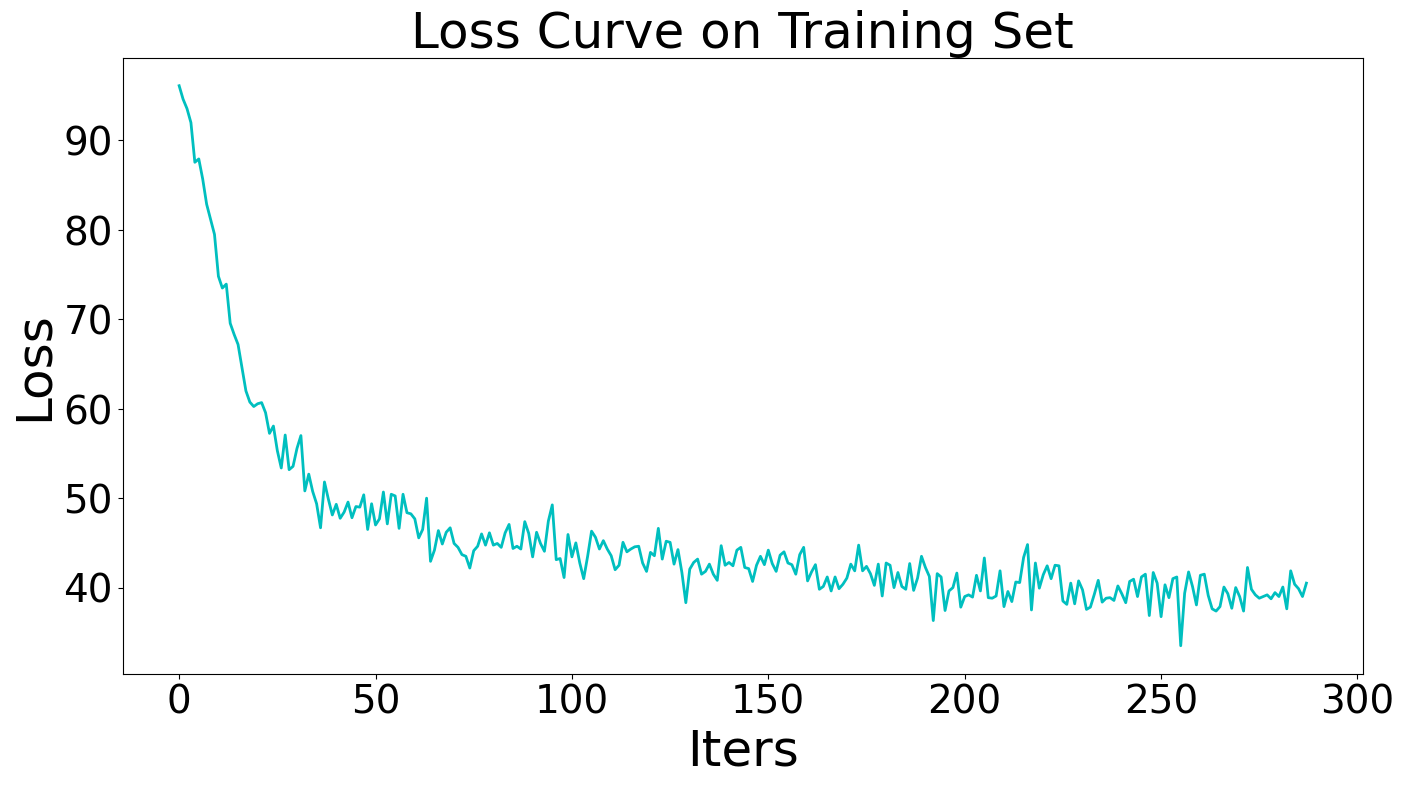

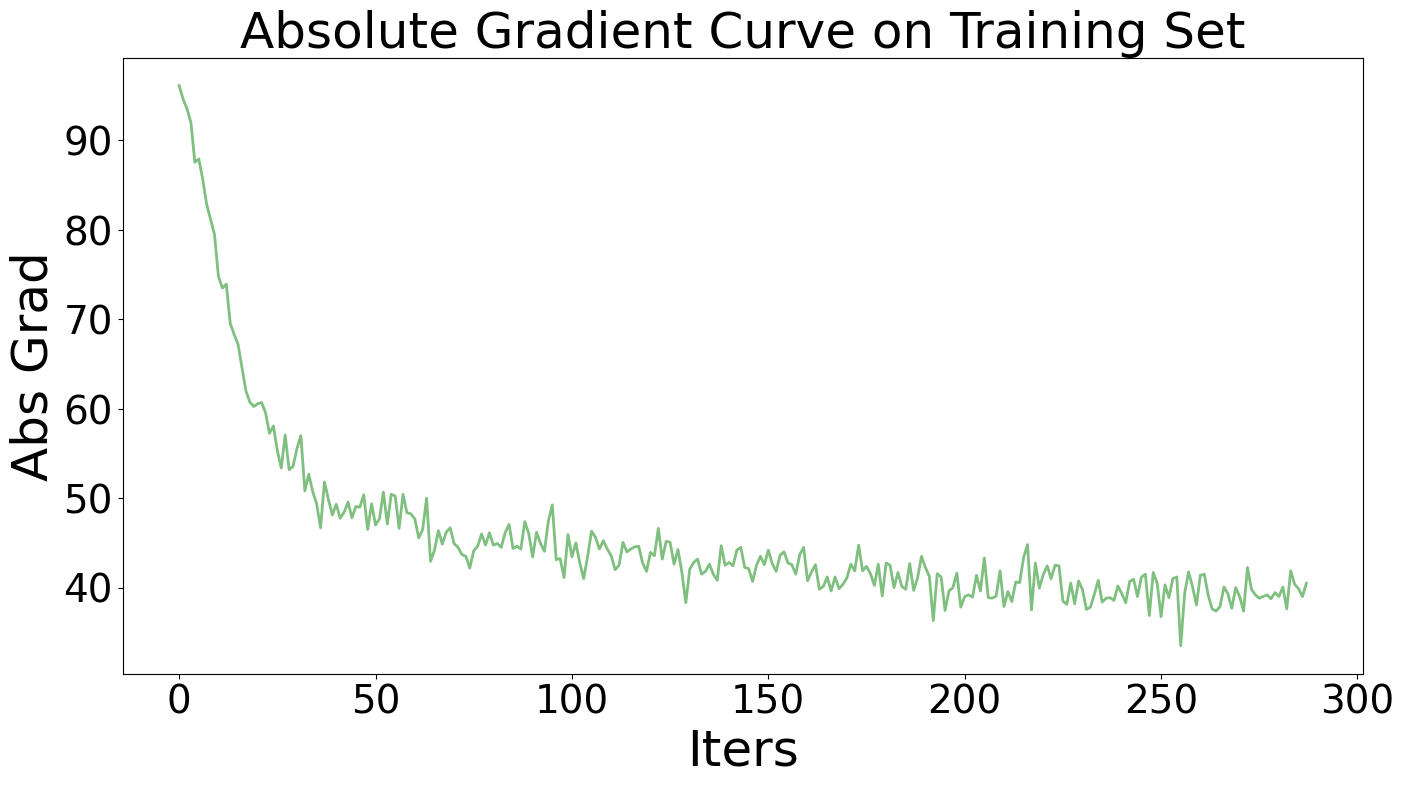

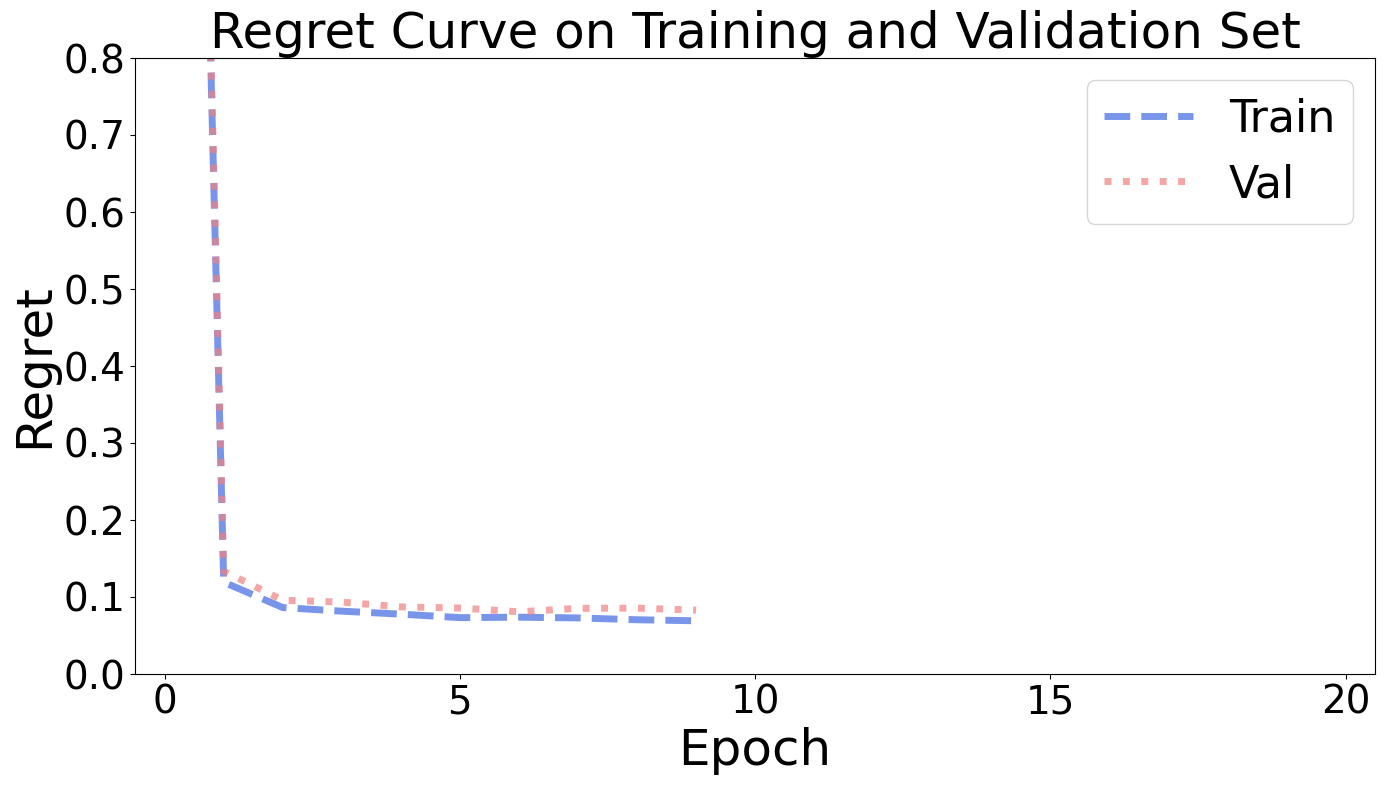

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:55<?, ?it/s]

Epoch   0, Train Regret: 320.7157%, Val Regret: 329.0384%


Epoch    0, Loss: -124.9755:   5%|██▋                                                   | 1/20 [02:06<22:15, 70.28s/it]

Epoch   1, Train Regret:  22.6006%, Val Regret:  24.4997%


Epoch    1, Loss: -320.6465:  10%|█████▍                                                | 2/20 [03:30<21:56, 73.13s/it]

Epoch   2, Train Regret:  16.7637%, Val Regret:  18.9873%


Epoch    2, Loss: -463.1792:  15%|████████                                              | 3/20 [04:45<21:28, 75.79s/it]

Epoch   3, Train Regret:  15.3291%, Val Regret:  17.2978%


Epoch    3, Loss: -701.2583:  20%|██████████▊                                           | 4/20 [06:08<21:20, 80.04s/it]

Epoch   4, Train Regret:  14.7889%, Val Regret:  16.7143%


Epoch    4, Loss: -862.4643:  25%|█████████████▌                                        | 5/20 [07:22<18:59, 75.99s/it]

Epoch   5, Train Regret:  14.4618%, Val Regret:  16.4685%


Epoch    5, Loss: -1072.7130:  30%|███████████████▉                                     | 6/20 [09:06<19:13, 82.40s/it]

Epoch   6, Train Regret:  14.2282%, Val Regret:  16.4006%


Epoch    6, Loss: -1132.5535:  35%|██████████████████▌                                  | 7/20 [10:28<18:21, 84.71s/it]

Epoch   7, Train Regret:  14.1263%, Val Regret:  16.5062%


Epoch    7, Loss: -1469.2817:  40%|█████████████████████▏                               | 8/20 [12:07<17:55, 89.62s/it]

Epoch   8, Train Regret:  13.8052%, Val Regret:  16.0882%


Epoch    8, Loss: -1676.6151:  45%|███████████████████████▊                             | 9/20 [13:27<16:09, 88.16s/it]

Epoch   9, Train Regret:  13.7263%, Val Regret:  16.1189%


Epoch    9, Loss: -1541.3286:  50%|██████████████████████████                          | 10/20 [15:18<15:28, 92.88s/it]

Epoch  10, Train Regret:  13.5822%, Val Regret:  15.9502%


Epoch   10, Loss: -2208.3042:  55%|████████████████████████████                       | 11/20 [17:31<15:43, 104.87s/it]

Epoch  11, Train Regret:  13.3918%, Val Regret:  16.1330%


Epoch   11, Loss: -1759.9009:  60%|██████████████████████████████▌                    | 12/20 [19:04<13:28, 101.04s/it]

Epoch  12, Train Regret:  13.2556%, Val Regret:  15.5038%


Epoch   12, Loss: -2023.9182:  65%|█████████████████████████████████▏                 | 13/20 [20:47<11:56, 102.30s/it]

Epoch  13, Train Regret:  13.1730%, Val Regret:  15.5029%


Epoch   13, Loss: -2559.0735:  70%|████████████████████████████████████▍               | 14/20 [22:21<09:33, 95.51s/it]

Epoch  14, Train Regret:  13.0656%, Val Regret:  15.4893%


Epoch   14, Loss: -2790.5464:  75%|██████████████████████████████████████▎            | 15/20 [24:53<09:50, 118.06s/it]

Epoch  15, Train Regret:  12.9843%, Val Regret:  15.3835%


Epoch   15, Loss: -3194.0359:  80%|████████████████████████████████████████▊          | 16/20 [26:35<07:25, 111.40s/it]

Epoch  16, Train Regret:  12.9962%, Val Regret:  15.4921%


Epoch   16, Loss: -2917.6470:  85%|███████████████████████████████████████████▎       | 17/20 [28:03<05:20, 106.67s/it]

Epoch  17, Train Regret:  12.9403%, Val Regret:  15.3984%


Epoch   17, Loss: -3452.2881:  90%|██████████████████████████████████████████████▊     | 18/20 [29:27<03:17, 98.69s/it]

Epoch  18, Train Regret:  13.0008%, Val Regret:  15.4109%

Early Stop!


Epoch   17, Loss: -3452.2881:  90%|██████████████████████████████████████████████▊     | 18/20 [29:27<03:16, 98.22s/it]



Evaluation:
Test Regret: 14.7492%
Training Elapsed Time: 522.15 Sec


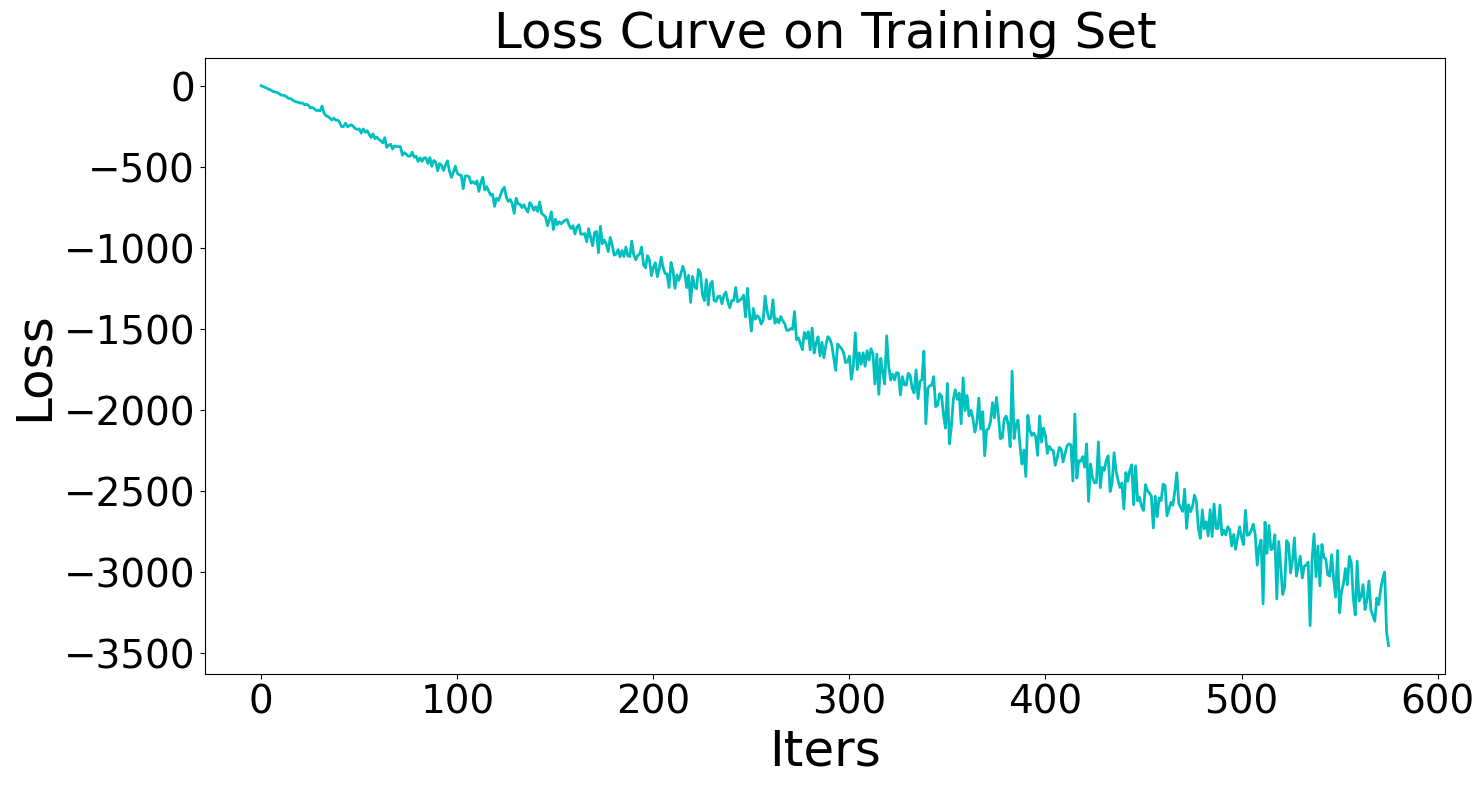

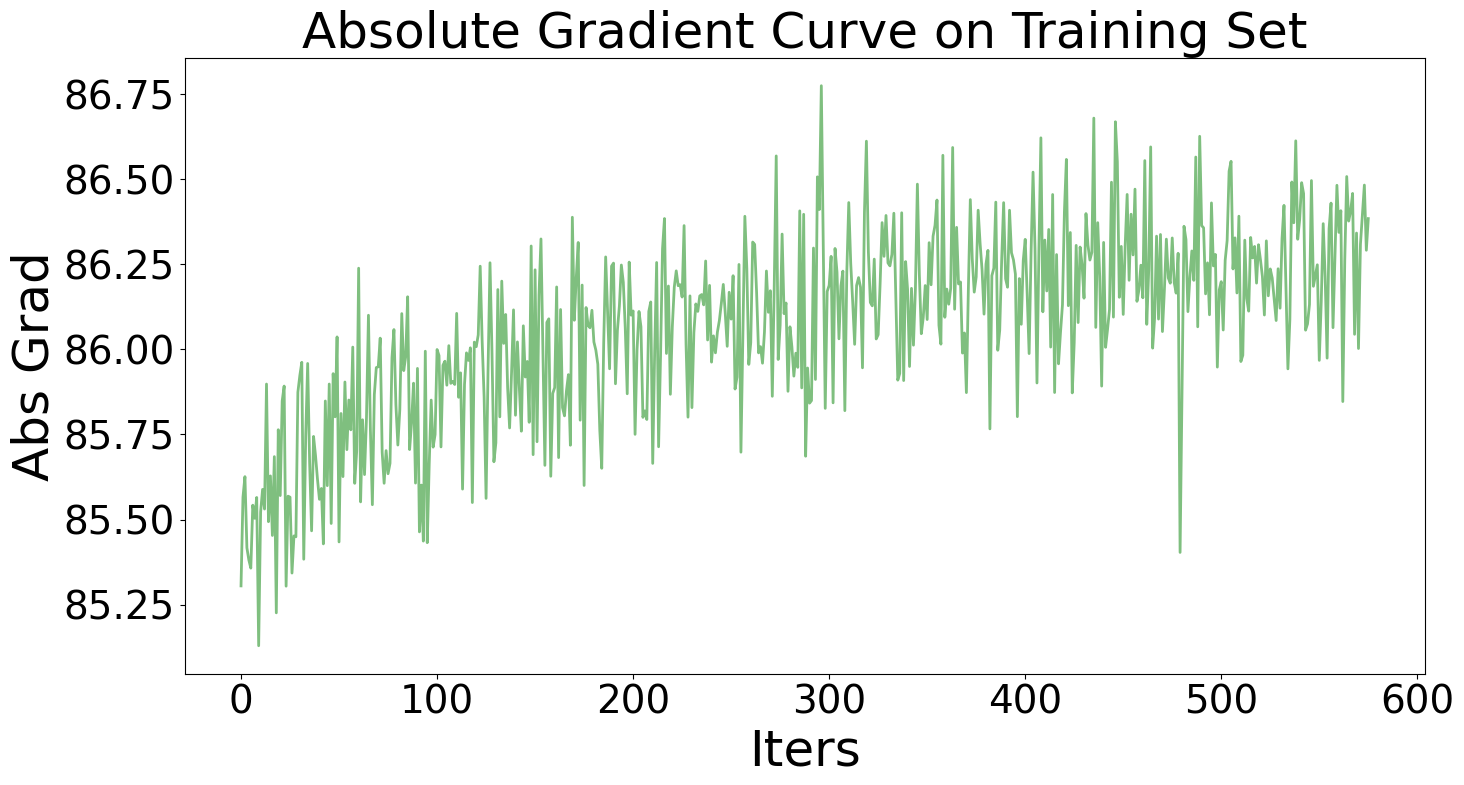

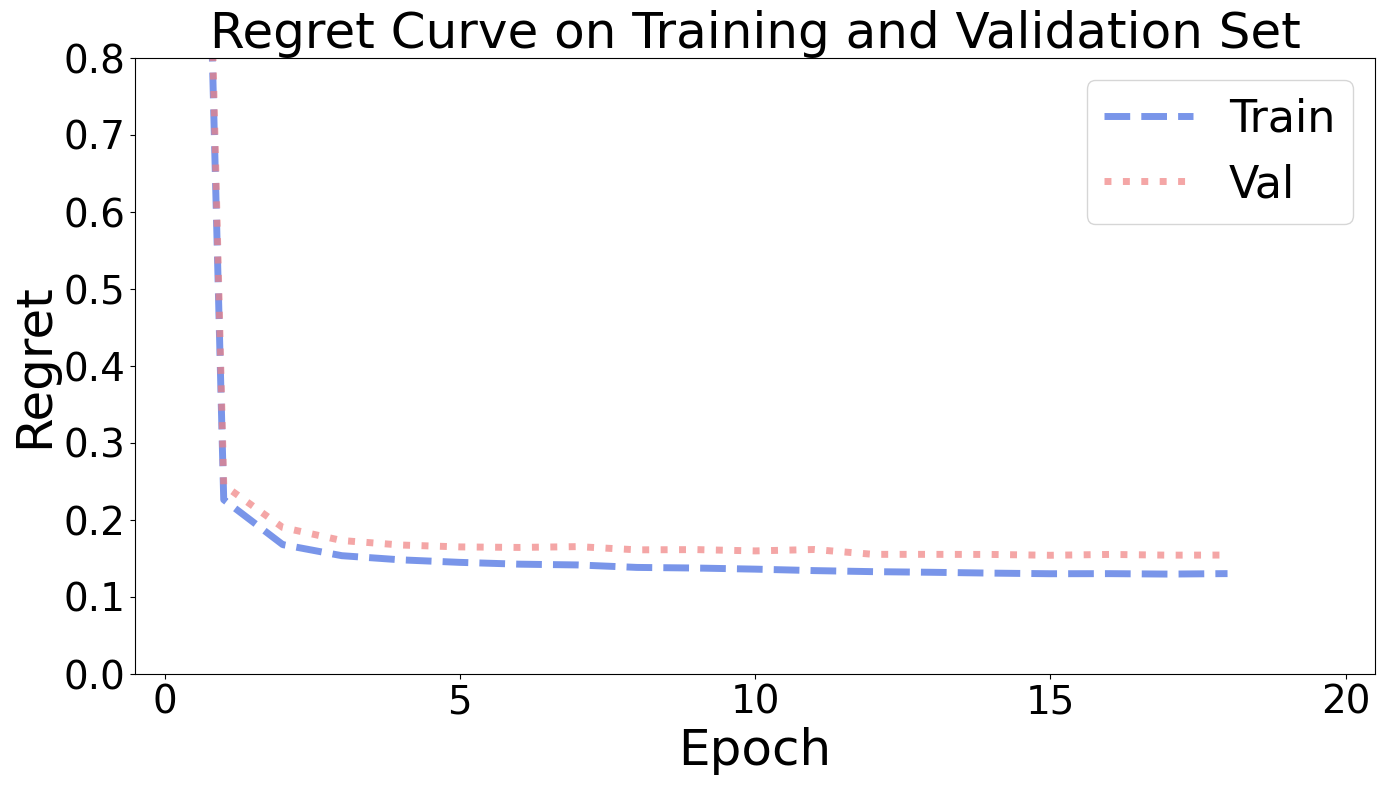

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)